# tf.data: 构建TensorFlow输入管道

tf.data API允许您从简单的、可重用的片段构建复杂的输入管道。例如，图像模型的管道可以从分布式文件系统中的文件中聚合数据，对每个图像应用随机扰动，并将随机选择的图像合并到一批进行训练。文本模型的管道可能涉及从原始文本数据中提取符号，将它们转换为使用查找表的嵌入标识符，并将不同长度的序列批量处理在一起。tf.data API可以处理大量数据，从不同的数据格式读取数据，并执行复杂的转换。

tf.data API引入了tf.data.Dataset。表示元素序列的数据集抽象，其中每个元素由一个或多个组件组成。例如，在一个图像管道中，一个元素可能是一个单一的训练示例，使用一对张量分量表示图像及其标签。


有两种不同的方法来创建数据集:

    数据源从存储在内存中的数据或从一个或多个文件中的数据构造数据集。
    
    数据转换从一个或多个tf.data.Dataset对象构造数据集。


In [2]:
import tensorflow as tf

In [3]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

### 基础结构

要创建输入管道，必须从数据源开始。例如，要从内存中的数据构造数据集，可以使用tf.data.Dataset.from_tensors()或tf.data.Dataset.from_tensor_slices()。另外，如果您的输入数据以推荐的TFRecord格式存储在文件中，那么您可以使用tf.data.TFRecordDataset()。

一旦你有了一个Dataset对象,您可以通过调用tf.data.Dataset对象 中的链接方法将其转换为一个新的Dataset。例如，您可以应用每个元素转换(如data .map())和多个元素转换(如data .batch())。请参阅tf.data.Dataset文档，以获取转换的完整列表。

Dataset对象是一个Python iterable。这使得使用for循环处理它的元素成为可能:

In [5]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [6]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


或者使用iter显式地创建一个Python迭代器，并使用next处理它的元素:

In [7]:
it = iter(dataset)

print(next(it).numpy())

8


或者，可以使用reduce转换来处理数据集元素，这样会将所有元素生成单个结果。下面的示例说明如何使用reduce转换来计算整数数据集的和。

In [8]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


### 数据集结构

数据集包含元素，每个元素都具有相同的(嵌套的)结构，结构中的单个组件可以是tf.TypeSpec可以表示的任何类型。包括tf.Tensor,tf.sparse.SparseTensor, tf.RaggedTensor, tf.TensorArray或 tf.data.Dataset.

Dataset.element_spec允许您检查每个元素组件的类型。该属性返回tf.TypeSpec 对象的嵌套结构，匹配元素的结构，元素可以是单个组件、组件元组或组件的嵌套元组。例如:

In [9]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [10]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [11]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [12]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [13]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

数据集转换支持任何结构的数据集。当使用Dataset.map()和Dataset.filter()转换时，将函数应用到每个元素，元素结构决定函数的参数:

In [14]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<TensorSliceDataset shapes: (10,), types: tf.int32>

In [15]:
for z in dataset1:
  print(z.numpy())

[6 6 2 5 9 8 5 5 3 5]
[2 2 5 7 8 9 2 6 3 3]
[2 7 8 7 5 4 2 6 5 8]
[8 3 3 4 9 2 2 9 6 8]


In [16]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<TensorSliceDataset shapes: ((), (100,)), types: (tf.float32, tf.int32)>

In [17]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<ZipDataset shapes: ((10,), ((), (100,))), types: (tf.int32, (tf.float32, tf.int32))>

In [18]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


### 读取输入数据

#### 处理NumPy数组

更多示例请参见加载NumPy数组。

如果所有输入数据都能载入内存，那么从它们创建数据集的最简单方法就是将它们转换为tf.Tensor对象，并使用Dataset.from_tensor_slices()。

In [19]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [20]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

注意:上面的代码片段将把特性和标签数组作为tf.constant()操作嵌入到您的TensorFlow图中。这对于小数据集很好，但是会浪费内存——因为数组的内容会被多次复制——并且可能会达到tf.GraphDef协议缓冲区 2GB的限制。

#### 使用 Python生成器

另一个可以很容易地被摄取为tf.data.Dataset的公共数据源是python生成器。


警告:虽然这是一种方便的方法，但它的可移植性和安全性有限。它必须在创建生成器的python进程中运行，并且仍然服从python GIL。


In [21]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1

In [22]:
for n in count(5):
  print(n)

0
1
2
3
4


Dataset.from_generator构造函数将python生成器转换为功能齐全的tf.data.Dataset。
构造函数接受callable作为输入，而不是迭代器。这使得它可以在结束时重新启动生成器。它接受一个可选的args参数，该参数作为可调用的参数传递。
output_types参数是必需的，因为tf.data 在内部构建了一个tf.Graph ，图的边需要tf.dtype。


In [23]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [24]:
for count_batch in ds_counter.repeat().batch(10).take(10):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


output_shapes参数不是必需的，但是非常值得推荐，因为许多tensorflow操作不支持秩未知的张量。如果特定轴的长度是未知的或可变的，则在output_shapes中将其设置为None。

还需要注意的是，output_shapes和output_types与其他数据集方法遵循相同的嵌套规则。

下面是演示这两个方面的示例生成器，它返回数组的元组，其中第二个数组是一个长度未知的向量。

In [25]:
def gen_series():
  i = 0
  while True:
    size = np.random.randint(0, 10)
    yield i, np.random.normal(size=(size,))
    i += 1

In [26]:
for i, series in gen_series():
  print(i, ":", str(series))
  if i > 5:
    break

0 : [-0.273  -0.2152 -0.4762 -1.4929  0.4788  2.1636 -1.1167 -1.3208]
1 : [-0.4002 -0.3294 -0.3608 -1.1546  0.0865]
2 : [-2.7455 -0.3802 -0.8081 -1.5963  1.0233  0.1619 -1.6281  0.9019]
3 : [ 0.8366 -0.3293  0.3744  1.6991  1.1025]
4 : [ 0.4742  0.27    1.1324  0.3156  2.0748 -0.3922]
5 : [-0.8191 -0.3807  0.3935  2.4901  1.5389  0.4699 -0.0659  0.874   0.0952]
6 : [ 0.8694 -1.1394  1.1666]


第一个输出是int32，第二个输出是float32。

第一项是标量，shape()，第二项是长度未知的向量，shape (None，)

In [27]:
ds_series = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((), (None,)))

ds_series

<FlatMapDataset shapes: ((), (None,)), types: (tf.int32, tf.float32)>

现在可以像常规的tf.data.Dataset那样使用它了。注意，在对具有可变形状的数据集进行批处理时，需要使用Dataset.padded_batch.

In [28]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[ 3 11  9  2 17  8  5 26 23  1]

[[-0.002  -1.6804 -0.3283 -0.903  -1.4602 -0.5592  0.      0.      0.    ]
 [-0.3653  0.6091 -1.3616 -1.0183  0.9123  0.      0.      0.      0.    ]
 [-0.5641  0.2284 -0.5509 -1.2232 -1.2511  0.1627  0.      0.      0.    ]
 [-0.5305  0.6684 -0.1996  0.      0.      0.      0.      0.      0.    ]
 [ 0.7119  0.0913  0.1884 -0.0203 -1.8348 -0.2653  0.0447  0.1084 -0.0888]
 [-0.7001  0.9644  0.0772 -0.3027 -0.5454  0.4868  0.8408  1.2419  0.    ]
 [ 1.2327  0.62   -1.1644 -0.7561  0.      0.      0.      0.      0.    ]
 [-1.427   0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.0901 -0.5669 -1.0739  1.2827 -0.4211  0.      0.      0.      0.    ]
 [-1.0708 -0.4423 -0.1481  0.      0.      0.      0.      0.      0.    ]]


对于一个更实际的示例，请尝试包装preprocessing.image.ImageDataGenerator为tf.data.Dataset。

首先下载数据:

In [30]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 34s 0us/step


创建image.ImageDataGenerator

In [31]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [32]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [33]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [34]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [35]:
for images, label in ds.take(1):
  print('images.shape: ', images.shape)
  print('labels.shape: ', labels.shape)


Found 3670 images belonging to 5 classes.
images.shape:  (32, 256, 256, 3)
labels.shape:  (32, 5)


#### 处理 TFRecord 数据

有关端到端示例，请参阅Loading TFRecords。

tf.data API支持各种文件格式，以便您可以处理内存中不能容纳的大型数据集。例如，TFRecord文件格式是一种简单的面向记录的二进制格式，许多TensorFlow应用程序都使用它来训练数据。tf.data.TFRecordDataset类使您能够将一个或多个TFRecord文件的内容变为文件流，作为输入管道的一部分。

下面是一个使用来自法国街道名称标志(FSNS)的测试文件的示例。


In [ ]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

4669440/7904079 [================>.............] - ETA: 3s

TFRecordDataset初始化器的filenames参数可以是字符串、字符串列表或tf.Tensor的字符串。因此，如果你有两组用于训练和验证目的的文件，你可以创建一个工厂方法，产生数据集，以文件名作为输入参数:

In [ ]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

许多TensorFlow项目在TFRecord文件中使用序列化的tf.train.Example记录。这些需要解码后才能进行检查:

In [ ]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

#### 使用文本数据

有关端到端示例，请参见 Loading Text。

许多数据集以一个或多个文本文件的形式分布。tf.data.TextLineDataset提供了从一个或多个文本文件中提取行的简单方法。给定一个或多个文件名，TextLineDataset将为这些文件的每行生成一个字符串值元素。

In [ ]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

In [ ]:
dataset = tf.data.TextLineDataset(file_paths)

下面是第一个文件的前几行:

In [ ]:
for line in dataset.take(5):
  print(line.numpy())

要在文件之间交替行，请使用Dataset.interleave。这使得将文件重组到一起变得更容易。以下是每份翻译的第一、二、三行:

In [ ]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
  if i % 3 == 0:
    print()
  print(line.numpy())

默认情况下，TextLineDataset生成每个文件的每一行，这可能不是我们想要的，例如，如果文件以标题行开始，或者包含注释。可以使用Dataset.skip()或Dataset.filter()转换来删除这些行。在这里，您跳过第一行，然后过滤器只查找剩余的行。

In [ ]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [ ]:
for line in titanic_lines.take(10):
  print(line.numpy())

In [ ]:
def survived(line):
  return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)

In [ ]:
for line in survivors.take(10):
  print(line.numpy())

#### 使用CSV数据

有关更多示例，请参见 Loading CSV Files和Loading Pandas DataFrames。

CSV文件格式是一种以纯文本形式存储表格数据的流行格式。

例如:


In [3]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

32768/30874 [===============================] - 0s 2us/step


In [4]:
df = pd.read_csv(titanic_file, index_col=None)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


如果你内存中的数据与适用于字典的Dataset.from_tensor_slices方法相同，那么允许这个数据很容易被导入:？？？

In [5]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


一种更可扩展的方法是根据需要从磁盘加载。

tf.data 模块提供了从符合RFC 4180的一个或多个CSV文件中提取记录的方法。

experimental.make_csv_dataset 函数是用于读取csv文件集的高级接口。它支持列类型推断和许多其他特性，如批处理和转移，以简化使用。


In [4]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

NameError: name 'titanic_file' is not defined

In [ ]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

如果只需要列的子集，可以使用select_columns参数。

In [5]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

NameError: name 'titanic_file' is not defined

In [ ]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

还有一个低级别的experimental.CsvDataset类，提供更细粒度的控制。它不支持列类型推断。相反，您必须指定每个列的类型。

In [ ]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string] 
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types , header=True)

for line in dataset.take(10):
  print([item.numpy() for item in line])

如果某些列是空的，这个低级接口允许您提供默认值而不是列类型。

In [7]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Writing missing.csv


In [8]:
# Creates a dataset that reads all of the records from two CSV files, each with
# four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (4,), types: tf.int32>

In [9]:
for line in dataset:
  print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


默认情况下，CsvDataset生成文件的每一行的每一列，这可能不是我们想要的，例如，如果文件以一个应该被忽略的头行开始，或者某些列在输入中是不需要的。可以分别使用header和select_cols参数删除这些行和字段。

In [10]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (2,), types: tf.int32>

In [11]:
for line in dataset:
  print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


#### Consuming sets of files使用文件集

这里有许多数据集分布为一组文件，其中每个文件都是一个示例。

In [12]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)


注意:这些图片是CC-BY授权的，详情请参阅LICENSE.txt。

根目录包含每个类的一个目录:

In [14]:
for item in flowers_root.glob("*"):
  print(item.name)

daisy
dandelion
LICENSE.txt
roses
sunflowers
tulips


每个类目录中的文件都是示例:

In [15]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\\xe4\xb9\x9d\xe7\xab\xa5\\.keras\\datasets\\flower_photos\\daisy\\18622672908_eab6dc9140_n.jpg'
b'C:\\Users\\\xe4\xb9\x9d\xe7\xab\xa5\\.keras\\datasets\\flower_photos\\sunflowers\\9558627290_353a14ba0b_m.jpg'
b'C:\\Users\\\xe4\xb9\x9d\xe7\xab\xa5\\.keras\\datasets\\flower_photos\\sunflowers\\6198569425_e953b9e6cc_m.jpg'
b'C:\\Users\\\xe4\xb9\x9d\xe7\xab\xa5\\.keras\\datasets\\flower_photos\\sunflowers\\8928658373_fdca5ff1b8.jpg'
b'C:\\Users\\\xe4\xb9\x9d\xe7\xab\xa5\\.keras\\datasets\\flower_photos\\tulips\\13857267684_d2a4b2630f_n.jpg'


使用tf.io.read_file 函数读取数据，从路径中提取标签，返回(图像，标签)对:

In [16]:
def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [17]:
for image_raw, label_text in labeled_ds.take(1):
  print(repr(image_raw.numpy()[:100]))
  print()
  print(label_text.numpy())

b"\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe1\x0cnXMP\x00://ns.adobe.com/xap/1.0/\x00<?xpacket begin='\xef\xbb\xbf' id='W5M0MpCehiHzreSzNTczk"

b'sunflowers'


### 批处理数据集的元素

#### 简单批处理

批处理最简单的形式是将数据集的n个连续的元素堆成一个元素。Dataset.batch()转换就是这样做的，使用与tf.stack()操作符相同的约束，应用于元素的每个组成部分:即对于每个组成部分i，所有元素都必须有一个形状完全相同的张量。

In [18]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3], dtype=int64), array([ 0, -1, -2, -3], dtype=int64)]
[array([4, 5, 6, 7], dtype=int64), array([-4, -5, -6, -7], dtype=int64)]
[array([ 8,  9, 10, 11], dtype=int64), array([ -8,  -9, -10, -11], dtype=int64)]
[array([12, 13, 14, 15], dtype=int64), array([-12, -13, -14, -15], dtype=int64)]


同时tf.data 试图传播形状信息，因为数据集的最后一批可能没有满，所以Dataset.batch的默认设置会导致未知批次大小，。注意形状中的Nones:

In [19]:
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

使用drop_remainder参数忽略最后一批，从而得到完整的形状传播:

In [20]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

#### 带填充的批量张量

上述方法适用于大小相同的张量。然而，许多模型(例如序列模型)可以使用不同大小的输入数据(例如：不同长度的序列)。要处理这种情况，Dataset.padded_batch转换允许您对不同形状的张量进行批处理，方法是指定一个或多个维度填充张量。

In [21]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()


[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



Dataset.padded_batch转换允许您为每个组成部分的每个维度设置不同的填充，它可以是可变长度(在上面的示例中由None表示)或恒定长度。也可以重写填充值，默认值为0。

### 训练工作流

#### 处理多个epochs

tf.data API提供了两种主要的方法来处理同一数据的多个epochs。
在多个epoch中迭代数据集的最简单方法是使用Dataset.repeat()转换。首先，创建一个巨大数据的数据集:


In [22]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [23]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

应用不带参数的Dataset.repeat()转换将无限期地重复输入。

Dataset.repeat 转换连接它的参数，而不表示一个epoch的结束和下一个epoch的开始。因为这是一个应用了 Dataset.repeat的Dataset.batch ，将产生跨epoch边界的批次:

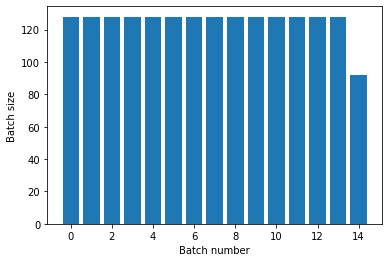

In [24]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

如果需要清除epoch间隔，请在repeat前使用Dataset.batch:

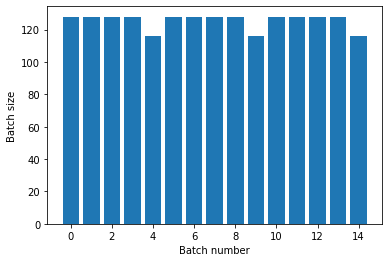

In [25]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

如果你想在每个epoch结束时执行自定义计算(例如收集统计数据)，那么最简单的方法就是在每个epoch上重新启动数据集迭代:

In [26]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


#### 随机变换输入数据

Dataset.shuffle()转换维护一个固定大小的缓冲区，并从该缓冲区中统一地随机选择下一个元素。

注意:虽然大的buffer_size会更彻底地打乱数据，但它们需要大量内存和大量时间。如果这成为一个问题，考虑使用Dataset.interleave跨文件。

添加索引到数据集，这样你可以看到效果:

In [28]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

因为buffer_size是100，而批大小是20，所以第一个batch不包含索引超过120的元素。

In [29]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 84  80  51  73  27  55  30  63  41  88  53  57  32  23  29   9 113  43
  34   6]


对于Dataset.batch，相对于Dataset.repeat的顺序很重要

直到shuffle缓冲区为空，Dataset.shuffle才表示一个epoch的结束。所以shuffle放置repeat之前会在进入下一个epoch之前显示出一个epoch中的每一个元素:

In [30]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[581 418 588 519 467 600 602 623 412 586]
[236 622 396 310 615 510 618 572 496 598]
[533 612 523 524 608 580 503 443]
[75 51 87 49 21 93 29 81  1 74]
[  3  96 106   5  26 102  33  57  52  76]


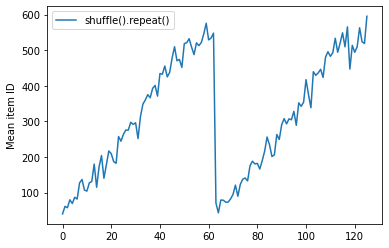

In [31]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

但是shuffle前的repeat将会把epoch边界混合在一起:

In [32]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[372 624   2 599 366  20 556 581 618  27]
[470 611 397 593  24 522 625 488  13 278]
[  0  32 478   7  17  19 420 617 487 498]
[ 25 472  38 605  51  49 586 558  15   4]
[492  58  18 569 565 572 563 525 477  57]
[533 567 591  53  14 582  73  55  65  70]
[535  36 600 620   9  52  47  48 594  77]
[623 484 540 577  86  50  45 536  60 615]
[ 83 387 101  68  59 103 609 513 555  29]
[ 89 537 542  76  30  37 110  39 510 608]
[519  40 109  66  42  16  62 601  96 114]
[575  34  23  95   5 416  64 130 137 551]
[ 54  63 612  12  21 104 471   6  74 138]
[135 147 585  46 118  87 115 587  10 404]
[ 72 159 128 150 468 157  94 396 108 479]


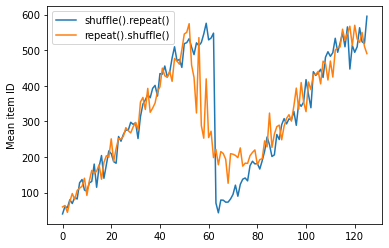

In [33]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

### 数据预处理

Dataset.map(f)转换将给定的函数f应用于输入数据集的每个元素，从而生成一个新的数据集。
它基于通常应用于函数式编程语言中的列表(和其他结构)的map()函数。函数f接受表示输入中单个元素的tf.Tensor对象，并返回将表示新数据集中单个元素的 tf.Tensor对象。
它的实现使用标准的TensorFlow操作将一个元素转换为另一个元素。

本节介绍如何使用Dataset.map()的常见示例。


#### 解码图像数据并调整其大小

在用真实图像数据训练神经网络时，常常需要将不同大小的图像转换为通用大小，以便将其批量处理为固定大小。

重建花文件名数据集:

In [34]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

编写一个操作数据集元素的函数。

In [35]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

测试它是否有效。

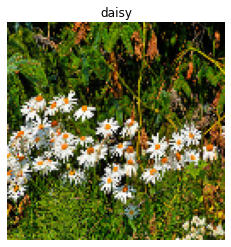

In [36]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

将其映射到数据集上。

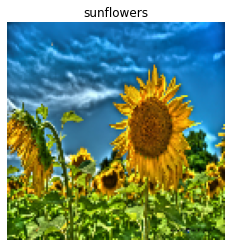

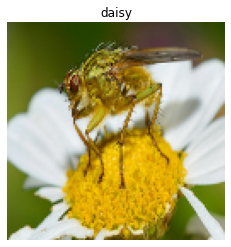

In [37]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

#### 应用任意Python逻辑

出于性能考虑，尽可能使用TensorFlow操作对数据进行预处理。但是，在解析输入数据时，有时调用外部Python库是有用的。可以在Dataset.map()转换中使用tf.py_function()操作。

例如，如果你想应用一个随机旋转，tf.image模块只有tf.image.rot90，它对图像增强不是很有用。

注意:tensorflow_addons在tensorflow_addons.image.rotate中有一个与TensorFlow兼容的旋转。

要演示tf.py_function，请尝试使用scipy.ndimage.rotate 函数:


In [38]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


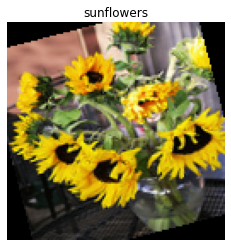

In [39]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

在Dataset.map中使用这个函数和在Dataset.from_generator中使用有相同的注意事项，你需要在应用这个函数时描述返回的形状和类型:

In [40]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


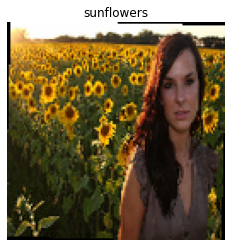

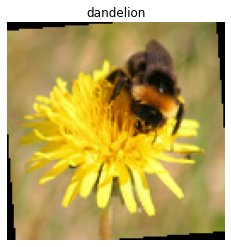

In [41]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

#### 解析tf.Example协议缓冲区消息

许多输入管道从TFRecord格式提取tf.train.Example 协议缓冲区消息。
每个tf.train.Example记录包含一个或多个“特性”，输入管道通常将这些特性转换为张量。


In [42]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

你可以在tf.data.Dataset之外使用一个tf.train.Example 原型来理解数据:

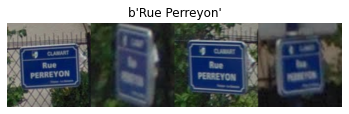

In [43]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [44]:
raw_example = next(iter(dataset))

In [45]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [46]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [47]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [48]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

#### 时间序列窗口

有关端到端时间序列的例子，见: Time series forecasting

时间序列数据通常以完整的时间轴组织。

使用简单的Dataset.range 说明:


In [49]:
range_ds = tf.data.Dataset.range(100000)

通常，基于这类数据的模型需要一个连续的时间片。

最简单的方法是对数据进行批处理:


使用批处理

In [50]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


或者，为了对接下来的一步做出密集的预测，你可能会将特征和标签相对移动一步:

In [51]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


为了预测整个窗口而不是固定的偏移量，您可以将批分成两部分:

In [52]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Take the first 5 steps
          batch[-5:])   # take the remainder

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


允许一批数据的特征与另一批数据的标签重叠，使用Dataset.zip:

In [53]:
feature_length = 10
label_length = 5

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:-5])

predict_5_steps = tf.data.Dataset.zip((features, labels))

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22 23 24]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32 33 34]


使用窗口

虽然使用Dataset.batch可行，但在某些情况下，您可能需要更好的控制。
Dataset.window方法提供了完全的控制，但是需要注意:它返回一个Datasets的Dataset 。
有关详细信息，请参阅Dataset structure


In [54]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


Dataset.flat_map 方法可以取一个datasets的dataset，并把它变成一个单一的dataset:

In [55]:
 for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

Cause: could not parse the source code:

for x in windows.flat_map(lambda x: x).take(30):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

for x in windows.flat_map(lambda x: x).take(30):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

在几乎所有的情况下，你会想要先.batch数据集:

In [56]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


现在，您可以看到shift参数控制了每个窗口移动的大小。

把这些放在一起，你可能会写这个函数:


In [57]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows


In [58]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


这样就很容易提取标签，如前所述:

In [59]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


#### 重采样

当使用类非常不平衡的数据集时，您可能需要重新取样数据集。
tf.data 提供了两种方法。信用卡欺诈数据集就是这类问题的一个很好的例子。


注意:有关完整教程，请参阅 Imbalanced Data.

In [60]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

69156864/69155632 [==============================] - 6s 0us/step


In [61]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

现在，看看类的分布，它是高度倾斜的:

In [62]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [63]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9954 0.0046]


使用不平衡数据集进行训练的一种常见方法是对其进行平衡。tf.data包括一些方法，使这个工作流可行:

##### 数据集采样

重采样数据集的一种方法是使用sample_from_datasets。这种方法更适用于当您每个类有单独的 data.Dataset时。

在这里，只需使用过滤器从信用卡欺诈数据生成重采样数据集:


In [64]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

Cause: could not parse the source code:

    .filter(lambda features, label: label==0)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

    .filter(lambda features, label: label==0)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

    .filter(lambda features, label: label==1)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

    .filter(lambda features, label: label==1)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.au

In [65]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


使用 tf.data.experimental.sample_from_datasets传递数据集，和每个数据集的权重:

In [67]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

现在数据集以50/50的概率生成每个类的样本:

In [68]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 0 1 0 0 0 0 0 1 0]
[0 1 0 0 1 0 0 1 0 1]
[0 0 0 1 1 0 1 0 1 0]
[0 1 1 1 0 1 1 1 1 1]
[1 0 0 1 0 0 0 1 1 0]
[0 0 1 1 1 1 0 0 0 0]
[1 1 1 0 1 0 0 1 0 1]
[0 1 0 1 1 0 0 0 0 1]
[0 0 1 1 1 0 0 1 1 0]
[0 0 0 1 1 0 1 1 0 0]


##### 拒绝重采样

上述experimental.sample_from_datasets 方法存在一个问题，每个类需要一个单独的tf.data.Dataset。可以使用Dataset.filter，但是会导致所有数据被加载两次。

data.experimental.rejection_resample 函数可以应用于数据集来重新平衡它，而且只加载它一次。元素将从数据集中被删除以达到平衡。

data.experimental.rejection_resample接受一个class_func参数。这个class_func应用于每个数据集元素，并用于确定一个样本属于哪个类，以达到平衡的目的。

creditcard_ds的元素已经是(特性、标签)对。所以class_func只需要返回这些标签:


In [69]:
def class_func(features, label):
  return label

重采样器还需要一个目标分布，以及可选的初始分布估计:

In [70]:
resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=fractions)

重采样器处理单独的样本，所以你必须在应用重采样器之前unbatch 数据集:

In [71]:
resample_ds = creditcard_ds.unbatch().apply(resampler).batch(10)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



重采样器从class_func的输出中返回creates (class, example)对。在本例中，样本已经是一对(特征，标签)，所以使用map来删除额外的标签副本:

In [72]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

现在数据集以50/50的概率生成每个类的样本:

In [73]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 1 1 0 0 0 1 1 1 1]
[0 0 0 0 1 1 1 1 1 1]
[0 0 1 1 1 1 1 1 0 1]
[0 0 0 0 1 0 1 1 0 1]
[1 1 1 1 0 1 1 0 0 1]
[0 1 0 1 1 1 1 0 1 0]
[0 1 1 1 1 1 1 0 0 0]
[0 0 1 0 0 0 1 0 1 1]
[1 1 0 0 0 0 1 0 0 0]
[1 1 0 1 0 0 0 1 1 0]


### 迭代器检查点

Tensorflow支持设置检查点，这样当你的训练过程重新启动时，它可以恢复最新的检查点来恢复大部分的进程。除了检查模型变量之外，您还可以检查数据集迭代器的进度。如果您有一个大型数据集，并且不想在每次重新启动时从头开始训练数据集，那么这可能非常有用。但是请注意，迭代器检查点可能很大，因为像shuffle和prefetch这样的转换需要迭代器中的缓冲元素。

要在检查点中包含迭代器，请将迭代器传递给tf.train.Checkpoint的构造函数。

In [74]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


注意:不可能对依赖于外部状态(如tf.py_function)的迭代器设置检查点。尝试这样做将会引发对外部状态的异常complaining。

### 通过tf.keras使用tf.data

tf.keras API简化了创建和执行机器学习模型的许多方面。它的.fit()、.evaluate()和.predict() API支持数据集作为输入。这里是一个快速的数据集和模型设置:

In [75]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [76]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

Model.fit和Model.evaluate需要使用(特征，标签)对形式的的数据集:

In [77]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1875/1875 [==============================] - 2s 1ms/step - loss: 0.6002 - accuracy: 0.7990
Epoch 2/2
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4626 - accuracy: 0.8419


如果你传递一个无限数据集，例如通过调用Dataset.repeat()，你只需要传入steps_per_epoch参数:

In [78]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 [==============================] - 0s 1ms/step - loss: 0.4876 - accuracy: 0.8391
Epoch 2/2
20/20 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.8547


对于评估，您可以传入评估step的数量:？？？

In [79]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 2s 854us/step - loss: 0.4295 - accuracy: 0.8541
Loss : 0.429468035697937
Accuracy : 0.8540999889373779


对于长数据集，设置要评估的steps:

In [80]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 1ms/step - loss: 0.3792 - accuracy: 0.8719
Loss : 0.3792129158973694
Accuracy : 0.871874988079071


在调用Model.predict时不需要标签。

In [81]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

(320, 10)


但是如果你传入一个包含标签的数据集，标签会被忽略:

In [82]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

(320, 10)
